In [7]:
#import subprocess
# Try to install matplotlib using pip before importing
#subprocess.check_call(['pip', 'install', 'torch'])
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error

In [8]:
# Generating fat random matrices
def generate_random_matrices(num_matrices, num_columns, vector_size=784):
    """
    Generates random matrices with columns drawn from a standard Gaussian distribution.
    
    Parameters:
    num_matrices (int): The number of matrices to generate.
    num_columns (list of int): The number of columns for each matrix.
    vector_size (int): The size of the vector to project.
    
    Returns:
    list of ndarray: The list of generated random matrices.
    """
    matrices = []
    for m in num_columns:
        # Create a matrix with columns drawn from a Gaussian distribution with varince 1/m
        matrix = np.random.normal(0, 1/m, (m, vector_size))
        # Normalize each column to have a unit l2 norm
        matrix /= np.linalg.norm(matrix, axis=0)
        matrices.append(matrix)
    return matrices

In [30]:
def mp(A, y, epsilon):
    """
    Matching Pursuit algorithm for sparse signal recovery.

    Parameters:
    A (numpy.ndarray): Measurement matrix (m x n).
    y (numpy.ndarray): Measurement vector (m x 1).
    epsilon (float): Tolerance for convergence.

    Returns:
    x_hat (numpy.ndarray): Estimated sparse signal (n x 1).
    """
    m, n = A.shape
    x_hat = np.zeros((n, 1))  # Estimated sparse signal
    residual = y.copy()  # Initialize residual to the measurement vector

    while np.linalg.norm(residual) > epsilon:  # Repeat until residual squared norm is less than epsilon
        # Calculate inner products
        h = A.T @ residual

        # Find index of maximum inner product
        max_index = np.argmax(np.abs(h))

        # Update x_hat
        x_hat[max_index] += h[max_index]

        # Update residual
        residual -= A[:, max_index].reshape(-1, 1) * h[max_index]
        
    return x_hat


In [32]:
# Function to plot the original and reconstructed image side by side
def plot_comparison(original_data, reconstructed_data, image_index=0):
    # Reshape the original image vector to 28x28
    original_image = original_data.iloc[image_index, 1:].values.reshape(28, 28)  # Skipping the label column
    
    # Extract the corresponding reconstructed image
    # Adjust the key as needed based on your actual reconstructed_images structure
    #reconstructed_image = reconstructed_data.iloc[image_index, 0:].values.reshape(28, 28)  # Skipping the label column
    reconstructed_image = reconstructed_data[:, image_index].reshape(28, 28)
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    
    plt.show()

In [61]:
def Calculate_MSE(original_data, reconstructed_data, image_index):
    """
    Calculate the mean squared error (MSE) between true and predicted values.

    Parameters:
    original_data (numpy.ndarray): Array of true values.
    reconstructed_data (numpy.ndarray): Array of predicted values.
    image_index (int): Number of chosen image
    Returns:
    mse (float): Mean squared error between true and predicted values.
    """
    original_image = original_data.iloc[image_index, 1:].values.reshape(28, 28)
    reconstructed_image = reconstructed_data[:, 0].reshape(28, 28)
    
    # Ensure inputs are numpy arrays
    y_true = np.array(original_image)
    y_pred = np.array(reconstructed_data.reshape(28, 28))
    
    # Calculate squared differences
    squared_diff = (y_true - y_pred) ** 2
    
    # Calculate mean squared error
    mse = np.mean(squared_diff)
    
    return mse

In [33]:
# Generate Reconstructed Images
def Images(test_Dataset, random_matrix, Amount, epsilon):
    """
    Generates Reconstructed Images
    
    Parameters:
    Amount (int): Amount of letter wanted to reconstruct
    test_Dataset m x p: test_Dataset
    random_matrices m x n: Random Gaussian matrices
    epsilon (float): Acceptable error 
    
    Returns:
    Reconstructed Images
    """
    m, p = test_Dataset.shape
    Reconstructed_Dataset = np.empty((m, 0))  # Initialize Reconstructed_Dataset
    for i in range(Amount):  # Iterate over columns
        Vector = test_Dataset[i]
        k = test_Dataset.iloc[:, i].astype(bool).sum()
        projected_y = np.dot(random_matrix, Vector).reshape(-1, 1)
        output = mp(random_matrix,projected_y,epsilon)
        Reconstructed_Dataset = np.column_stack((Reconstructed_Dataset, output))
    return Reconstructed_Dataset

In [55]:
#Load files
train_data = pd.read_csv('mnist_train.csv', header=None)
test_Dataset = train_data.iloc[:, 1:].T # Remove the first column
#test_data = pd.read_csv('mnist_test.csv', header=None)
#test_Dataset = test_data.iloc[:, 1:].T # Remove the first column

In [56]:
# Generate fat random matrices
random_matrices = generate_random_matrices(num_matrices=7, num_columns=[100, 200, 300, 400, 500, 600, 700])

In [57]:
Reconstructed_Dataset = Images(test_Dataset, random_matrices[4], Amount=1, epsilon=100)

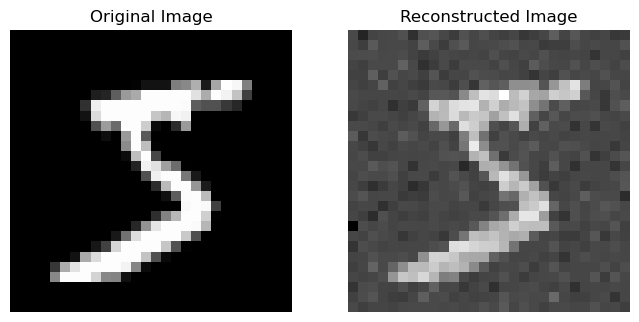

In [59]:
# Call the function with an example image index 
plot_comparison(train_data, Reconstructed_Dataset, image_index=0)

MSE Error for M=100 4227.470711019846


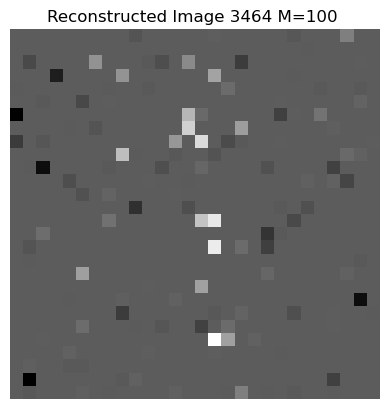

MSE Error for M=200 2215.5147583485887


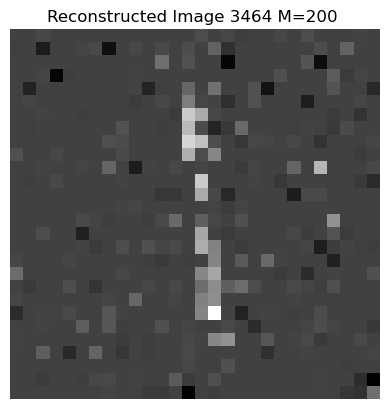

MSE Error for M=300 65.70927410414602


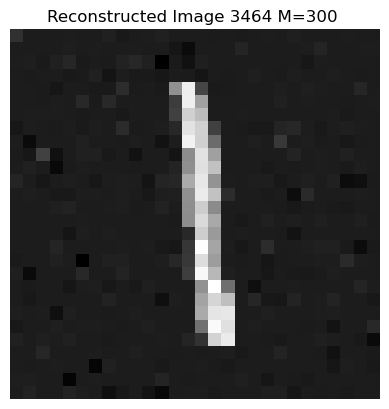

MSE Error for M=400 3.839837873791011e-09


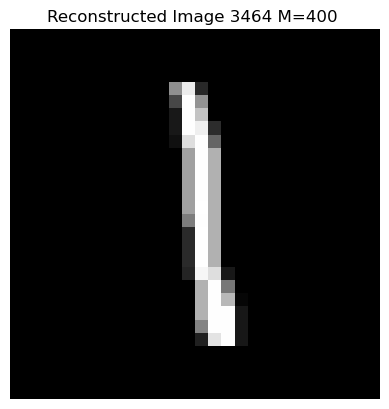

MSE Error for M=500 2.9069724034987706e-13


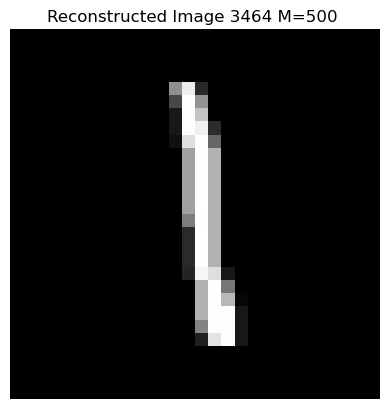

MSE Error for M=600 2.1086321097684135e-13


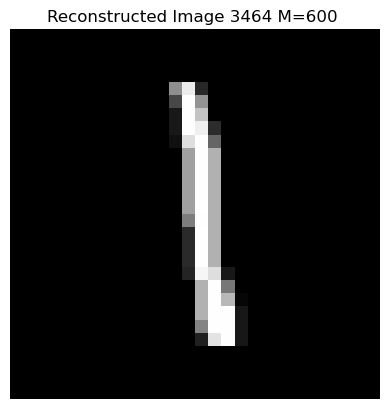

MSE Error for M=700 1.9859688470632925e-13


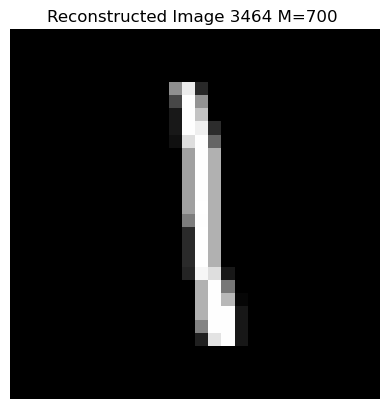

In [64]:
#For a single iteration
for Matrix in range(7):
    Measurements = Matrix*100 + 100
    column = 3464
    Vector = test_Dataset[column]
    projected_y = np.dot(random_matrices[Matrix], Vector).reshape(-1, 1)
    Vector = test_Dataset[0]
    k = test_Dataset.iloc[:, column].astype(bool).sum()
    output = mp(random_matrices[Matrix],projected_y,epsilon=1e-10)
    print(f"MSE Error for M={Measurements}", Calculate_MSE(train_data,output,3464))
    
    # Example: Visualize the first reconstructed image from the first projection
    first_reconstructed_image = output.reshape(28, 28)   # Adjust indices based on actual structure
    plt.imshow(first_reconstructed_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Reconstructed Image 3464 M={Measurements} ")
    plt.savefig(f"MP/M_{Measurements}.png", bbox_inches='tight')
    plt.show()

In [ ]:
# For a single iteration
#column = 1
#Vector = test_Dataset[column]
#projected_y = np.dot(random_matrices[0], Vector).reshape(-1, 1)
#Vector = test_Dataset[0]
#k = test_Dataset.iloc[:, column].astype(bool).sum()
#output = omp(random_matrices[0],projected_y,k)

In [ ]:
## Example: Visualize the first reconstructed image from the first projection
#first_reconstructed_image = output.reshape(28, 28)   # Adjust indices based on actual structure
#plt.imshow(first_reconstructed_image, cmap='gray')
#plt.title("Reconstructed Image")
#plt.show()